<a href="https://colab.research.google.com/github/geedoubledee/data620_project3/blob/main/DATA620_Project3_GDavis_BDavidoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA620: Project 3
#### by Glen Davis and Brett Davidoff

In [117]:
# Import libraries
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import names
import numpy as np
import random
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.inspection import permutation_importance
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import textwrap as tw

We load the names dataset from NLTK and shuffle the order of the entries so that it's random.

In [118]:
# Load names dataset from NLTK
nltk.download('names', quiet=True)
male_names = [(name, 'male') for name in names.words('male.txt')]
female_names = [(name, 'female') for name in names.words('female.txt')]
all_names = male_names + female_names

# Shuffle the dataset to ensure it's randomly ordered
random.seed(4657)
random.shuffle(all_names)
ln = len(all_names)
print(f"\nThe first 10 out of {ln} total entries in the shuffled names dataset:\n")
wrapped = tw.fill(str(all_names[:10]))
print(wrapped)


The first 10 out of 7944 total entries in the shuffled names dataset:

[('Iseabal', 'female'), ('Andee', 'female'), ('Englebart', 'male'),
('Susi', 'female'), ('Row', 'female'), ('Delmar', 'male'), ('Faina',
'female'), ('Nero', 'male'), ('Dena', 'female'), ('Crista', 'female')]


We check for any overlap between the groups, i.e. names that are labeled both male and female.

In [119]:
def intersection(lst1, lst2):
    lst3 = [name for (name, _) in lst1 + lst2]
    seen = set()
    overlap = [name for name in lst3 if name in seen or seen.add(name)]
    return overlap
overlap = intersection(male_names, female_names)
print(f"\nNames labeled both male and female:\n")
wrapped = tw.fill(str(overlap))
print(wrapped)


Names labeled both male and female:

['Abbey', 'Abbie', 'Abby', 'Addie', 'Adrian', 'Adrien', 'Ajay',
'Alex', 'Alexis', 'Alfie', 'Ali', 'Alix', 'Allie', 'Allyn', 'Andie',
'Andrea', 'Andy', 'Angel', 'Angie', 'Ariel', 'Ashley', 'Aubrey',
'Augustine', 'Austin', 'Averil', 'Barrie', 'Barry', 'Beau', 'Bennie',
'Benny', 'Bernie', 'Bert', 'Bertie', 'Bill', 'Billie', 'Billy',
'Blair', 'Blake', 'Bo', 'Bobbie', 'Bobby', 'Brandy', 'Brett', 'Britt',
'Brook', 'Brooke', 'Brooks', 'Bryn', 'Cal', 'Cam', 'Cammy', 'Carey',
'Carlie', 'Carlin', 'Carmine', 'Carroll', 'Cary', 'Caryl', 'Casey',
'Cass', 'Cat', 'Cecil', 'Chad', 'Chris', 'Chrissy', 'Christian',
'Christie', 'Christy', 'Clair', 'Claire', 'Clare', 'Claude', 'Clem',
'Clemmie', 'Cody', 'Connie', 'Constantine', 'Corey', 'Corrie', 'Cory',
'Courtney', 'Cris', 'Daffy', 'Dale', 'Dallas', 'Dana', 'Dani',
'Daniel', 'Dannie', 'Danny', 'Darby', 'Darcy', 'Darryl', 'Daryl',
'Deane', 'Del', 'Dell', 'Demetris', 'Dennie', 'Denny', 'Devin',
'Devon', 'Dion', 'Dionis

We relabel the overlapping names as neutral and check the gender distributions of the entries in the names dataset.

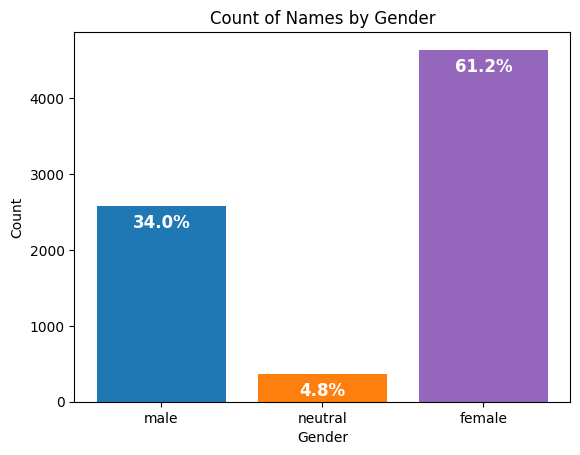

In [120]:
neutral_names = [(name, "neutral") for name in overlap]
male_names = [(name, gender) for (name, gender) in male_names if name not in overlap]
female_names = [(name, gender) for (name, gender) in female_names if name not in overlap]
all_names = male_names + neutral_names + female_names
x = ["male", "neutral", "female"]
y = [len(male_names), len(neutral_names), len(female_names)]
fig, ax = plt.subplots()
bars = ax.bar(x, y, color = ["tab:blue", "tab:orange", "tab:purple"])
ax.set_xlabel("Gender")
ax.set_ylabel("Count")
ax.set_title("Count of Names by Gender")
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        perc_str = str(round(100 * height / len(all_names), 1)) + "%"
        ax.text(bar.get_x() + bar.get_width()/2., height - 100,
                '%s' % perc_str, ha = "center", va = "top",
                color = "white", weight = "bold", size = 12)
autolabel(bars)
plt.show()

There are about 1.8 times as many female entries in the names dataset as there are male entries after relabeling the gender neutral names. This is only a moderate class imbalance and should not affect the predictive power of our models. We won't try to predict neutral names, so we remove those entries from further consideration and reshuffle all remaining entries in the names dataset.

In [121]:
all_names = male_names + female_names
random.shuffle(all_names)

We define a function to extract a small number of features from the entries in the names dataset: a) the last letter of the name; b) the first letter of the name; c) the count of total characters within the name; and d) the count of vowel characters within the name.

In [122]:
def feature_extraction(name):
    name = name.lower()
    features = {
        "last_letter": name[-1],
        "first_letter": name[0],
        "length": len(name),
        "num_vowels": sum(name.count(v) for v in "aeiou"),
    }
    return features

We apply the feature extraction function to the entries in the names dataset.

In [123]:
# Extract features
features = [feature_extraction(name) for name, gender in all_names]
print(f"\nExtracted features for the first 10 entries in the shuffled names dataset:\n")
wrapped = tw.fill(str(features[:10]))
print(wrapped)


Extracted features for the first 10 entries in the shuffled names dataset:

[{'last_letter': 'n', 'first_letter': 's', 'length': 7, 'num_vowels':
2}, {'last_letter': 'n', 'first_letter': 'm', 'length': 5,
'num_vowels': 2}, {'last_letter': 'h', 'first_letter': 'w', 'length':
7, 'num_vowels': 3}, {'last_letter': 'e', 'first_letter': 'e',
'length': 5, 'num_vowels': 3}, {'last_letter': 's', 'first_letter':
'r', 'length': 7, 'num_vowels': 2}, {'last_letter': 'a',
'first_letter': 'e', 'length': 6, 'num_vowels': 2}, {'last_letter':
'a', 'first_letter': 'd', 'length': 6, 'num_vowels': 3},
{'last_letter': 'y', 'first_letter': 'a', 'length': 5, 'num_vowels':
1}, {'last_letter': 'a', 'first_letter': 'm', 'length': 5,
'num_vowels': 3}, {'last_letter': 'n', 'first_letter': 'w', 'length':
7, 'num_vowels': 3}]


We vectorize the features so that the categorical features are represented numerically for faster model building and testing.

In [124]:
# Convert categorical features to numerical features
vectorizer = DictVectorizer()
features_vect = vectorizer.fit_transform(features).toarray()

We extract the response variable: the gender labels.

In [125]:
# Extract labels
labels = np.array([gender for name, gender in all_names])
print(f"\nLabels for the first 10 entries in the shuffled names dataset:\n")
wrapped = tw.fill(str(labels[:10]))
print(wrapped)


Labels for the first 10 entries in the shuffled names dataset:

['male' 'female' 'female' 'female' 'male' 'female' 'female' 'male'
'female' 'male']


We split the vectorized features and the labels into train, validate, and test sets.

In [126]:
# Split the dataset into train_validate and test sets
sss = ShuffleSplit(n_splits = 1, test_size = 500, random_state = 42)
sss.get_n_splits(features_vect, labels)
train_validate_index, test_index = next(sss.split(features_vect, labels))
x_train_validate, x_test = features_vect[train_validate_index], features_vect[test_index]
y_train_validate, y_test = labels[train_validate_index], labels[test_index]

# Perform another split on the train_validate set
sss = ShuffleSplit(n_splits = 1, test_size = 500, random_state = 43)
sss.get_n_splits(x_train_validate, y_train_validate)
train_index, validate_index = next(sss.split(x_train_validate, y_train_validate))
x_train, x_validate = x_train_validate[train_index], x_train_validate[validate_index]
y_train, y_validate = y_train_validate[train_index], y_train_validate[validate_index]

We train a Decision Tree Classifier and a Naive Bayes Classifier, and we calculate the predictive accuracy for both models using the validate set.

In [127]:
# Train a Decision Tree Classifier
classifierDT = DecisionTreeClassifier()
classifierDT.fit(x_train, y_train)

# Train a Naive Bayes Classifier
classifierNB = GaussianNB()
classifierNB.fit(x_train, y_train)

# Evaluate DTC on the validation set
preds_val_DT = classifierDT.predict(x_validate)
acc_val_DT = accuracy_score(y_validate, preds_val_DT)
print(f"\nDecision Tree Classifier: Validation Set Predictive Accuracy: {acc_val_DT}")

# Evaluate NBC on the validation set
preds_val_NB = classifierNB.predict(x_validate)
acc_val_NB = accuracy_score(y_validate, preds_val_NB)
print(f"Naive Bayes Classifier: Validation Set Predictive Accuracy: {acc_val_NB}")


Decision Tree Classifier: Validation Set Predictive Accuracy: 0.808
Naive Bayes Classifier: Validation Set Predictive Accuracy: 0.774


Using a small number of straightforward text features derived from the names, the Decision Tree Classifier and the Naive Bayes Classifier both have okay performance. However, the Decision Tree Classifier's predictive accuracy of 80.8% beats the Naive Bayes Classifier's score by 3.4%.

In an attempt to improve both models' predictive accuracy, we expand the feature extraction function so that it derives a wider variety of features from the names. The new features include: the ratio of vowel characters to total characters; the first two letters of the name; the last two letters of the name; the first three letters of the name; the last three letters of the name; the count of consonant characters; the consonant to vowel character ratio; and all unique character sequences of lengths two to four.

In [128]:
# Increase feature selection complexity
def feature_extraction2(name):
    name = name.lower()
    features = feature_extraction(name)
    features["vowel_to_length_ratio"] = features["num_vowels"] / features["length"]
    features["first_2_letters"] = name[:2]
    features["last_2_letters"] = name[-2:]
    features["first_3_letters"] = name[:3] if features["length"] > 2 else 0
    features["last_3_letters"] = name[-3:] if features["length"] > 2 else 0
    features["num_consonants"] = sum(name.count(c) for c in "bcdfghjklmnpqrstvwxyz")
    features["consonant_to_vowel_ratio"] = features["num_consonants"] / features["num_vowels"] if features["num_vowels"] > 0 else 0
    for n in range(2, 5): # Add all 2- to 4-letter ngrams
        for i in range(len(name) - n + 1):
            ngram = name[i:i+n]
            features[f"{n}gram_{ngram}"] = features.get(f"{n}gram_{ngram}", 0) + 1
    return features

We apply the newly expanded function to the names dataset and update the train, validate, and test sets to include the new features. Importantly, we use the same indices we generated for the original splits so that the observations remain in the same order and groups. Then we refit the classifiers and calculate their new predictive accuracy scores.

In [129]:
# Extract and vectorize new features, then split the data again using the same indices as earlier
features = [feature_extraction2(name) for name, gender in all_names]
features_vect = vectorizer.fit_transform(features).toarray()
x_train_validate, x_test = features_vect[train_validate_index], features_vect[test_index]
y_train_validate, y_test = labels[train_validate_index], labels[test_index]
x_train, x_validate = x_train_validate[train_index], x_train_validate[validate_index]
y_train, y_validate = y_train_validate[train_index], y_train_validate[validate_index]

# Refit the models
classifierDT.fit(x_train, y_train)
classifierNB.fit(x_train, y_train)

# Evaluate new DTC on the validation set
preds_val_DT = classifierDT.predict(x_validate)
acc_val_DT = accuracy_score(y_validate, preds_val_DT)
print(f"\nDecision Tree Classifier: Validation Set Predictive Accuracy: {acc_val_DT}")

# Evaluate new NBC on the validation set
preds_val_NB = classifierNB.predict(x_validate)
acc_val_NB = accuracy_score(y_validate, preds_val_NB)
print(f"Naive Bayes Classifier: Validation Set Predictive Accuracy: {acc_val_NB}")


Decision Tree Classifier: Validation Set Predictive Accuracy: 0.858
Naive Bayes Classifier: Validation Set Predictive Accuracy: 0.88


The Decision Tree Classifier's performance improved by 5%, but the Naive Bayes Classifier's performance improved by 10.6%, and it now beats the Decision Tree Classifier by 2.2%.

We take a look at the 20 most important features in the Decision Tree Classifier. Calculating feature importance for Naive Bayes Classifiers requires permutation and is unfortunately too costly computation-wise in this instance, so we skip the calculations for that model.

In [130]:
# Extract feature importance estimates from the DTC
feature_imp_DT = classifierDT.feature_importances_

# Get feature names from the DictVectorizer
feature_names = vectorizer.get_feature_names_out()

# Combine names and importances
feature_imp_DT = zip(feature_names, feature_imp_DT)
feature_imp_DT = sorted(feature_imp_DT, key=lambda x: x[1], reverse=True)

# Print top N most important features
print("\nTop 20 features in the Decision Tree Classifier:\n")
for feature, importance in feature_imp_DT[:20]:
    print(f"{feature}: {importance}")



Top 20 features in the Decision Tree Classifier:

last_letter=a: 0.17514107327445277
last_letter=e: 0.0954949791964926
last_letter=i: 0.052677750828446245
last_letter=y: 0.025702685417148822
2gram_ly: 0.022096900575909805
num_vowels: 0.019571358059975272
last_3_letters=een: 0.012748720861938232
3gram_ann: 0.010468823859989018
2gram_is: 0.009021947886407393
2gram_ry: 0.00879624608020424
last_2_letters=ah: 0.008701350080725083
vowel_to_length_ratio: 0.00865004136625055
length: 0.008046841399684907
2gram_li: 0.007308029588470398
last_letter=l: 0.007195161048870635
2gram_be: 0.006759980334491631
2gram_el: 0.005091104435371184
last_2_letters=th: 0.004257593812350817
first_letter=c: 0.004195190052561389
consonant_to_vowel_ratio: 0.0038544037457838845


Since our feature list includes all unique character sequences of lengths two to four, there are a lot more features than just these 20, and many of them are likely not contributing much to either model other than overfitting. We limit the number of features the models use to the 20 best features according to a Chi-squared test, then refit the classifiers and calculate their new predictive accuracy scores.

In [131]:
#Restrict the features to the 20 best according to a chi2 test
support = SelectKBest(chi2, k=20).fit(x_train, y_train)
vectorizer.restrict(support.get_support())
features_vect = vectorizer.fit_transform(features).toarray()
x_train_validate, x_test = features_vect[train_validate_index], features_vect[test_index]
y_train_validate, y_test = labels[train_validate_index], labels[test_index]
x_train, x_validate = x_train_validate[train_index], x_train_validate[validate_index]
y_train, y_validate = y_train_validate[train_index], y_train_validate[validate_index]

# Refit the models
classifierDT.fit(x_train, y_train)
classifierNB.fit(x_train, y_train)

# Evaluate new DTC on the validation set
preds_val_DT = classifierDT.predict(x_validate)
acc_val_DT = accuracy_score(y_validate, preds_val_DT)
print(f"\nDecision Tree Classifier: Validation Set Predictive Accuracy: {acc_val_DT}")

# Evaluate new NBC on the validation set
preds_val_NB = classifierNB.predict(x_validate)
acc_val_NB = accuracy_score(y_validate, preds_val_NB)
print(f"Naive Bayes Classifier: Validation Set Predictive Accuracy: {acc_val_NB}")


Decision Tree Classifier: Validation Set Predictive Accuracy: 0.848
Naive Bayes Classifier: Validation Set Predictive Accuracy: 0.88


After restricting the number of features, the Decision Tree Classifier's predictive accuracy decreases by 1% on the validation set, but the Naive Bayes Classifier's predictive accuracy remains the same. Finally, we calculate the predictive accuracy for both models on the test set.

In [132]:
# Evaluate new DTC on the validation set
preds_val_DT = classifierDT.predict(x_test)
acc_val_DT = accuracy_score(y_test, preds_val_DT)
print(f"\nDecision Tree Classifier: Validation Set Predictive Accuracy: {acc_val_DT}")

# Evaluate new NBC on the validation set
preds_val_NB = classifierNB.predict(x_test)
acc_val_NB = accuracy_score(y_test, preds_val_NB)
print(f"Naive Bayes Classifier: Validation Set Predictive Accuracy: {acc_val_NB}")


Decision Tree Classifier: Validation Set Predictive Accuracy: 0.838
Naive Bayes Classifier: Validation Set Predictive Accuracy: 0.876


Both models perform a little worse on the test set, with the Naive Bayes Classifier beating the Decision Tree Classifier by 3.8%. Still, using a limited number of features, both of their final predictive accuracy scores are respectable.